# Nearest Neighbor

As our first approach, we will develop what we call a Nearest Neighbor Classifier. This classifier has nothing to do with **Neural Networks** and it is very rarely used in practice, but it will allow us to get an idea about the baseline approach to an image classification problem.

The Nearest Neighbor classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, the classifier classifies every test image by comparing to all training images and transfering the labels of the most similar training examples

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'utils/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


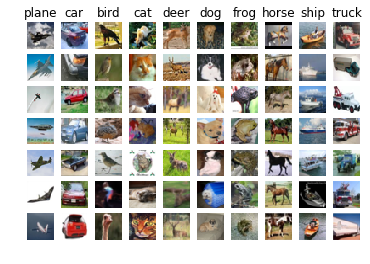

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
# Sample 5000 data points from the training set and 500 data points from test set

num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
X_train.shape

(5000, 32, 32, 3)

Hint: Use `np.reshape` function.

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


One of the simplest possibilities is to compare the images pixel by pixel and add up all the differences. In other words, given two images and representing them as vectors $I1$, $I2$, a reasonable choice for comparing them might be the **L1 distance**:
$$d_1 (I_1, I_2) = \sum_{p} \left| I^p_1 - I^p_2 \right|$$

There are many other ways of computing distances between vectors. Another common choice could be to instead use the **L2 distance**, which has the geometric interpretation of computing the euclidean distance between two vectors. The distance takes the form:
$$d_2 (I_1, I_2) = \sqrt{\sum_{p} \left( I^p_1 - I^p_2 \right)^2}$$

It is interesting to consider differences between the two metrics. In particular, the L2 distance is much more unforgiving than the L1 distance when it comes to differences between two vectors. That is, the L2 distance prefers many medium disagreements to one big one. L1 and L2 distances (or equivalently the L1/L2 norms of the differences between a pair of images) are the most commonly used special cases of a p-norm.

In [7]:
import numpy as np

class NearestNeighbor(object):
    def __init__(self):
        pass

    def train(self, X, y):
        """ X is N x D where each row is an example. Y is 1-dimension of size N """
        # the nearest neighbor classifier simply remembers all the training data
        self.Xtr = X
        self.ytr = y

    def predict(self, X, distance='L1'):
        """ X is N x D where each row is an example we wish to predict label for """
        num_test = X.shape[0]
        # lets make sure that the output type matches the input type
        Ypred = np.zeros(num_test, dtype=self.ytr.dtype)

        # loop over all test rows
        for i in range(num_test):
            # find the nearest training image to the i'th test image
            # using the L1 distance (sum of absolute value differences)
            if distance == 'L1':
                distances = np.sum(np.abs(self.Xtr - X[i,:]), axis=1)
            # using the L2 distance (sum of absolute value differences)
            if distance == 'L2':
                distances = np.sqrt(np.sum(np.square(self.Xtr - X[i,:]), axis=1))
            min_index = np.argmin(distances) # get the index with smallest distance
            Ypred[i] = self.ytr[min_index] # predict the label of the nearest example

        return Ypred

In [8]:
nn = NearestNeighbor() # create a Nearest Neighbor classifier class
nn.train(X_train, y_train) # train the classifier on the training images and labels
y_test_pred = nn.predict(X_test) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print('accuracy: %f' % (np.mean(y_test_pred == y_test)))

accuracy: 0.290000


In [9]:
y_test_pred = nn.predict(X_test, distance='L2')
print('accuracy: %f' % (np.mean(y_test_pred == y_test)))

accuracy: 0.274000


## k Nearest Neighbor

The k-nearest neighbors algorithm (kNN) is a non-parametric method used for classification and regression. 
In both cases, the input consists of the **k** closest training examples in the feature space.

Here we use a ready-to-use API from scikit-learn to build our kNN classifier.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
nn = KNeighborsClassifier(n_neighbors=1)
nn.fit(X_train, y_train)
y_test_pred = nn.predict(X_test) # predict labels on the test images
# and now print the classification accuracy, which is the average number
# of examples that are correctly predicted (i.e. label matches)
print('accuracy: %f' % (np.mean(y_test_pred == y_test)))

accuracy: 0.274000


In [12]:
for k in range(2, 5):
    nn = KNeighborsClassifier(n_neighbors=k)
    nn.fit(X_train, y_train)
    y_test_pred = nn.predict(X_test)
    print('K =', k)
    print('accuracy: %f' % (np.mean(y_test_pred == y_test)))

K = 2
accuracy: 0.224000
K = 3
accuracy: 0.272000
K = 4
accuracy: 0.272000
